## 001 Run

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../../')
# keras expects data to be encoded in a particular way, to_categorical does this encoding for us (one-hot encoding)
from keras.utils.np_utils import to_categorical
import libs.importing as importing
import pandas as pd
import os
import libs.render as render
import libs.cnn_models as cnn_models
import libs.analysis as analysis
import libs.normalization as normalization
from importlib import reload
import libs.data_prep as data_prep
import numpy as np

from pylab import rcParams
rcParams['figure.figsize'] = (10,8)

In [4]:
# LOAD PATCH DATA REFERENCES

# directory setup
data_source = '../a2aaceaa'
train_dir = os.path.join(data_source, 'train')
test_dir = os.path.join(data_source, 'test')
val_dir = os.path.join(data_source, 'val')

# get references to the data we want
train_patches_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned_shuffled.csv'))
train_data_reader = importing.PatchDataReader(os.path.join(train_dir, 'patches'), train_patches_df)

test_patches_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned_shuffled.csv'))
test_data_reader = importing.PatchDataReader(os.path.join(test_dir, 'patches'), test_patches_df)

val_patches_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned_shuffled.csv'))
val_data_reader = importing.PatchDataReader(os.path.join(val_dir, 'patches'), val_patches_df)

In [5]:
## READ PATCH DATA

# load train, test, and validation data
x_train, y_train = train_data_reader.read_data()
x_test, y_test = test_data_reader.read_data()
x_val, y_val = val_data_reader.read_data()

# LOG RESULTS
## Visualize the patches
data_prep.log_patch_data_reader(train_dir, train_data_reader)
data_prep.log_patch_data_reader(test_dir, test_data_reader)
data_prep.log_patch_data_reader(val_dir, val_data_reader)

In [19]:
# INSPECT : look at class 1 = benign and 2 = papilloma, 3 = dysplasia+carcinoma

#render.plot_image(x_train[0])
#print(y_train[122])

#render.plot_image(x_train[2])
#print(y_train[2])

#render.plot_image(x_train[8])
#print(y_train[8])


In [6]:
## CONVERT CLASSES TO KERAS FORMAT
# keras expects classes to be number from 0-N, we are using 1-N numbering so we need to convert.
# then we also have to change the classes to one-hot encoding

y_train_oh = to_categorical(y_train - 1)
y_test_oh  = to_categorical(y_test - 1)
y_val_oh   = to_categorical(y_val - 1)

In [7]:
# NORMALIZATION

m, std = normalization.dataset_mean_and_std(x_train)

x_train = (x_train - m) / std
x_test  = (x_test - m) / std
x_val   = (x_val - m) / std

In [11]:
## MODEL : load from file, show summary, and compile
reload(cnn_models)

model = cnn_models.model_3layer(num_classes=4)
display(model.summary())

# parameters:
learning_rate = 1e-3

model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics=["accuracy"])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
activation_9 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 48)        27696     
_________________________________________________________________
activation_10 (Activation)   (None, 64, 64, 48)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 48)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 128)       55424     
__________

None

In [12]:
data_prep.check_for_nans(x_train)
data_prep.check_for_nans(x_test)
data_prep.check_for_nans(x_val)

print(y_train[:100], y_test[:100], y_val[:100])

[4 4 2 2 4 3 2 4 4 1 1 4 4 3 1 3 4 1 4 4 2 2 4 4 4 1 4 4 3 4 4 2 2 4 4 4 4
 1 2 1 1 1 4 1 2 1 4 4 4 4 4 4 3 2 4 3 4 1 1 2 1 4 1 4 4 1 4 1 4 4 1 4 4 1
 4 4 4 1 4 4 1 4 4 4 4 4 4 1 1 2 2 2 4 4 1 4 4 1 2 1] [4 4 1 3 2 4 4 4 4 4 3 1 4 3 3 2 1 3 3 1 2 3 3 1 3 4 1 3 3 2 2 3 2 1 2 3 3
 4 1 2 4 3 4 4 3 1 3 2 4 3 1 1 3 4 1 3 4 3 3 1 3 4 4 3 3 3 4 1 4 1 1 1 3 3
 4 4 3 3 3 3 2 1 2 3 2 3 3 2 1 3 3 1 3 4 3 1 3 3 4 3] [4 1 1 1 1 1 1 4 2 4 4 1 1 4 1 4 4 4 2 4 2 4 4 1 1 1 1 3 4 1 4 3 3 2 4 4 3
 2 4 1 1 4 4 1 1 1 4 1 4 4 1 1 1 4 3 2 2 1 2 4 4 4 1 3 4 4 3 4 4 3 3 1 4 3
 1 1 1 1 1 1 1 4 1 4 4 1 4 4 4 1 2 2 4 4 4 1 1 4 1 1]


In [13]:
## Now Let's do a run with data augmentation
reload(cnn_models)
from keras.preprocessing.image import ImageDataGenerator

# parameters
epochs = 10
batch_size = 16

datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=30,                    # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                     # Randomly zoom image 
        width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,                 # randomly flip images
        vertical_flip=False)                  # randomly flip images


#datagen.fit(x_train)


#history = model.fit_generator(datagen.flow(x_train,y_train_oh, batch_size=batch_size),
#                              epochs = epochs, validation_data = (x_test,y_test_oh),
#                              workers = 4,
#                              verbose = 1, steps_per_epoch = x_train.shape[0] # batch_size
#                              , callbacks=[cnn_models.annealer()])


history = model.fit(x_train,y_train_oh, batch_size=batch_size,
                              epochs = epochs,
                              validation_data = (x_test,y_test_oh), shuffle=True,
                              verbose = 1, callbacks=[cnn_models.annealer(2)])

Train on 4402 samples, validate on 419 samples
Epoch 1/10
4402/4402 [==============================] - 19s 4ms/step - loss: 0.9147 - acc: 0.7058 - val_loss: 1.7221 - val_acc: 0.3747
Epoch 2/10
4402/4402 [==============================] - 18s 4ms/step - loss: 0.8294 - acc: 0.7274 - val_loss: 2.2818 - val_acc: 0.3723
Epoch 3/10
4402/4402 [==============================] - 18s 4ms/step - loss: 0.7801 - acc: 0.7390 - val_loss: 1.6354 - val_acc: 0.3795
Epoch 4/10
4402/4402 [==============================] - 18s 4ms/step - loss: 0.7316 - acc: 0.7451 - val_loss: 1.7298 - val_acc: 0.4177
Epoch 5/10
4402/4402 [==============================] - 18s 4ms/step - loss: 0.7166 - acc: 0.7517 - val_loss: 1.4884 - val_acc: 0.4893
Epoch 6/10
4402/4402 [==============================] - 18s 4ms/step - loss: 0.6856 - acc: 0.7524 - val_loss: 1.8977 - val_acc: 0.4010
Epoch 7/10
4402/4402 [==============================] - 18s 4ms/step - loss: 0.6436 - acc: 0.7649 - val_loss: 2.1300 - val_acc: 0.3866
Epoch 8/

In [14]:
render.plot_training_and_validation_curves(history)
y_pred_oh = model.predict(x_val)

cm = render.setup_confusion_matrix(y_pred_oh, x_val, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=2)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

Precision (specificity): 54.105%
Recall (sensitivity): 50.343%
Accuracy: 72.385%
F1: 48.794%


In [15]:
## CONTOUR LEVEL ANALYSIS
reload(analysis)

analysis.plot_contour_predictions(val_data_reader, model, val_dir, norm_data=(m, std))
analysis.contour_statistics(val_data_reader, model, val_dir, norm_data=(m, std))

hgv-dffcce57 [0.02098595 0.1036546  0.15790501 0.7174545 ] 3
mdi-461bdebc [0.5421363  0.01022313 0.09626814 0.35137245] 0
odi-28084697 [0.58420604 0.05121152 0.1567734  0.20780896] 2
hgv-2cdb69f6 [0.01684314 0.4243705  0.12303504 0.4357514 ] 2
mdi-b731a91f [0.01824412 0.01134429 0.06498532 0.90542626] 3
hgv-99fc12a1 [0.01890695 0.4103427  0.12032265 0.45042768] 1
odi-bf734aed [0.03024207 0.22454265 0.11539684 0.62981844] 1
odi-1767f1a2 [0.765079   0.07324677 0.13183476 0.02983948] 0


In [16]:
model.save('model_001.h5')

In [18]:
reload(cnn_models)

model = cnn_models.model_3layer(num_classes=4)
#display(model.summary())

# parameters:
learning_rate = 1e-3

model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics=["accuracy"])

# parameters
epochs = 20
batch_size = 32

datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=30,                    # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                     # Randomly zoom image 
        width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,                 # randomly flip images
        vertical_flip=False)                  # randomly flip images


#datagen.fit(x_train)


#history = model.fit_generator(datagen.flow(x_train,y_train_oh, batch_size=batch_size),
#                              epochs = epochs, validation_data = (x_test,y_test_oh),
#                              workers = 4,
#                              verbose = 1, steps_per_epoch = x_train.shape[0] # batch_size
#                              , callbacks=[cnn_models.annealer()])

history = model.fit(x_train,y_train_oh, batch_size=batch_size,
                              epochs = epochs,
                              validation_data = (x_test,y_test_oh), shuffle=True,
                              verbose = 1, callbacks=[cnn_models.annealer(2)])

Train on 4402 samples, validate on 419 samples
Epoch 1/20
4402/4402 [==============================] - 14s 3ms/step - loss: 0.9373 - acc: 0.6876 - val_loss: 1.4807 - val_acc: 0.3652
Epoch 2/20
4402/4402 [==============================] - 12s 3ms/step - loss: 0.8113 - acc: 0.7260 - val_loss: 1.4114 - val_acc: 0.4224
Epoch 3/20
4402/4402 [==============================] - 12s 3ms/step - loss: 0.7738 - acc: 0.7347 - val_loss: 1.6318 - val_acc: 0.4057
Epoch 4/20
4402/4402 [==============================] - 12s 3ms/step - loss: 0.7159 - acc: 0.7474 - val_loss: 1.9159 - val_acc: 0.3842
Epoch 5/20
4402/4402 [==============================] - 12s 3ms/step - loss: 0.6649 - acc: 0.7544 - val_loss: 1.6912 - val_acc: 0.4463
Epoch 6/20
4402/4402 [==============================] - 12s 3ms/step - loss: 0.6315 - acc: 0.7617 - val_loss: 2.0949 - val_acc: 0.3675
Epoch 7/20
4402/4402 [==============================] - 12s 3ms/step - loss: 0.5969 - acc: 0.7771 - val_loss: 1.5248 - val_acc: 0.4248
Epoch 8/

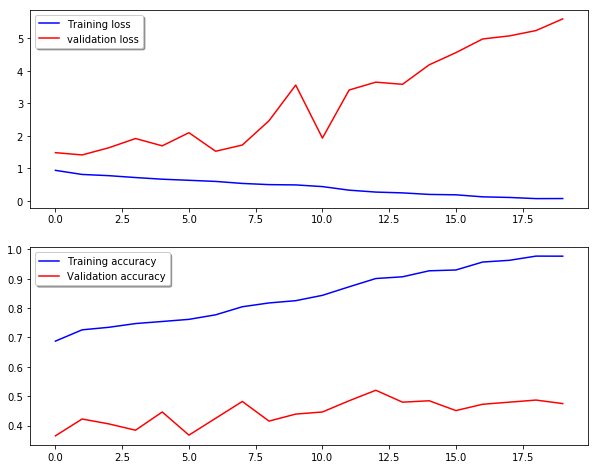

Precision (specificity): 56.849%
Recall (sensitivity): 59.646%
Accuracy: 67.364%
F1: 55.402%


In [19]:
render.plot_training_and_validation_curves(history)
y_pred_oh = model.predict(x_val)

cm = render.setup_confusion_matrix(y_pred_oh, x_val, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=2)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [20]:
## CONTOUR LEVEL ANALYSIS
reload(analysis)

analysis.plot_contour_predictions(val_data_reader, model, val_dir, norm_data=(m, std))
analysis.contour_statistics(val_data_reader, model, val_dir, norm_data=(m, std))

hgv-dffcce57 [1.0767709e-06 5.8119136e-01 1.3199821e-02 4.0560773e-01] 3
mdi-461bdebc [7.0221287e-01 5.6243758e-04 4.9020037e-02 2.4820463e-01] 0
odi-28084697 [0.64524466 0.01338787 0.1376137  0.20375378] 2
hgv-2cdb69f6 [0.00089078 0.16741805 0.12738459 0.70430654] 2
mdi-b731a91f [1.505135e-04 1.636913e-02 4.578061e-02 9.376997e-01] 3
hgv-99fc12a1 [6.0903189e-05 9.0315056e-01 1.2687952e-03 9.5519722e-02] 1
odi-bf734aed [6.8770443e-09 6.3665503e-01 1.6703753e-04 3.6317790e-01] 1
odi-1767f1a2 [7.5570661e-01 2.8808698e-02 2.1473643e-01 7.4816548e-04] 0


In [21]:
model.save('model_001_r2.h5')

In [23]:
reload(cnn_models)

model = cnn_models.model_3layer(num_classes=4)
#display(model.summary())

# parameters:
learning_rate = 1e-3

model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics=["accuracy"])

# parameters
epochs = 5
batch_size = 32

datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=30,                    # randomly rotate images in the range (degrees, 0 to 180)
        #zoom_range = 0.1,                     # Randomly zoom image 
        width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,                 # randomly flip images
        vertical_flip=False)                  # randomly flip images


datagen.fit(x_train)


history = model.fit_generator(datagen.flow(x_train,y_train_oh, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test_oh),
                              workers = 4,
                              verbose = 1, steps_per_epoch = x_train.shape[0] # batch_size
                              , callbacks=[cnn_models.annealer(2)])

#history = model.fit(x_train,y_train_oh, batch_size=batch_size,
#                              epochs = epochs,
#                              validation_data = (x_test,y_test_oh), shuffle=True,
#                              verbose = 1, callbacks=[cnn_models.annealer(2)])

Epoch 1/5
4402/4402 [==============================] - 390s 88ms/step - loss: 0.6539 - acc: 0.7631 - val_loss: 2.1805 - val_acc: 0.3866
Epoch 2/5
4402/4402 [==============================] - 388s 88ms/step - loss: 0.4262 - acc: 0.8354 - val_loss: 2.9314 - val_acc: 0.4010
Epoch 3/5
4402/4402 [==============================] - 388s 88ms/step - loss: 0.3244 - acc: 0.8768 - val_loss: 3.1670 - val_acc: 0.4391
Epoch 4/5
4402/4402 [==============================] - 388s 88ms/step - loss: 0.2741 - acc: 0.8971 - val_loss: 3.8977 - val_acc: 0.3604
Epoch 5/5
4402/4402 [==============================] - 387s 88ms/step - loss: 0.3208 - acc: 0.8876 - val_loss: 4.6348 - val_acc: 0.3508


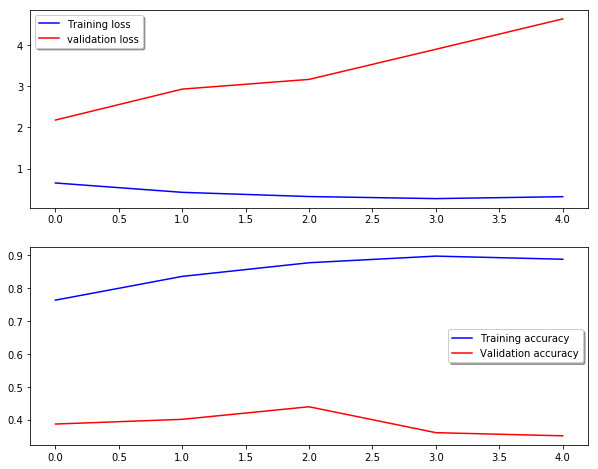

Precision (specificity): 64.719%
Recall (sensitivity): 61.408%
Accuracy: 75.314%
F1: 58.609%


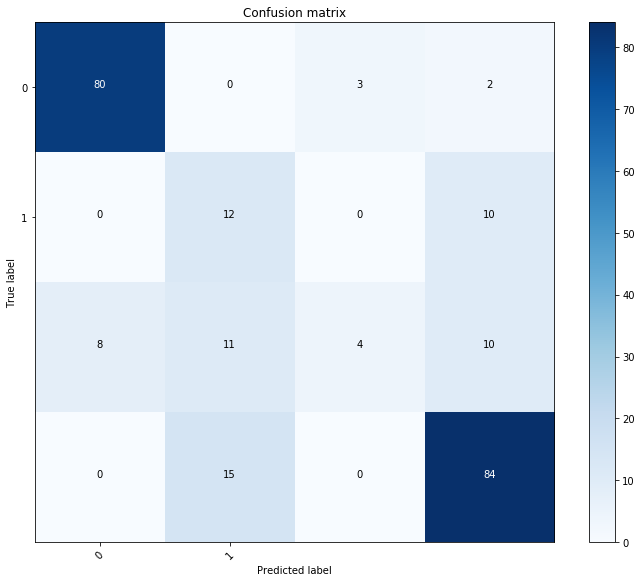

In [24]:
render.plot_training_and_validation_curves(history)
y_pred_oh = model.predict(x_val)

cm = render.setup_confusion_matrix(y_pred_oh, x_val, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=2)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [25]:
## CONTOUR LEVEL ANALYSIS
reload(analysis)

analysis.plot_contour_predictions(val_data_reader, model, val_dir, norm_data=(m, std))
analysis.contour_statistics(val_data_reader, model, val_dir, norm_data=(m, std))

hgv-dffcce57 [0.00446146 0.39059702 0.00714138 0.59780014] 3
mdi-461bdebc [0.8607705  0.00267827 0.00814145 0.12840968] 0
odi-28084697 [0.5688147  0.01483483 0.3365052  0.07984526] 2
hgv-2cdb69f6 [0.01998676 0.44357368 0.03212716 0.5043124 ] 2
mdi-b731a91f [2.5286257e-02 7.8118166e-05 4.5467120e-02 9.2916840e-01] 3
hgv-99fc12a1 [0.06747266 0.42647278 0.00652795 0.49952653] 1
odi-bf734aed [1.4937337e-04 5.9789139e-01 1.9349665e-03 4.0002429e-01] 1
odi-1767f1a2 [8.9135802e-01 1.0024855e-02 9.8455340e-02 1.6179608e-04] 0


In [26]:
model.save('model_001_r3.h5')